In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 170M/170M [00:02<00:00, 63.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


ship  cat  car  car


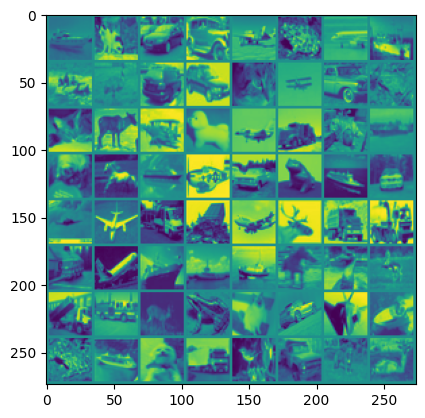

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [ ]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 3x32x32 -> 32x32x32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32x32 -> 32x16x16
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # 32x16x16 -> 64x16x16
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # 64x16x16 -> 128x16x16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128x16x16 -> 128x8x8

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Flattened size 128*8*8
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)  # Flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation since it's for classification
        return x


model = CNN()
summary(model, (3, 32, 32))


# DIY: Hyperparameters  -----------------------------------------
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimiter
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# DIY: Hyperparameters  -----------------------------------------


epoch_number = 0

EPOCHS = 20
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0 = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    model.train(True)
    for i, data in enumerate(training_loader):
        inputs, labels = data

        # DIY: Training Loop  -----------------------------------------

        # Zeros all left over gradient
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and Perform Backward Propagation
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # DIY: Training Loop  -----------------------------------------


        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    model.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    if valid_loss < best_vloss:
        best_vloss = valid_loss
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end = time.time()-t_0
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end} sec")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
            Conv2d-4          [-1, 128, 16, 16]          73,856
         MaxPool2d-5            [-1, 128, 8, 8]               0
            Linear-6                  [-1, 256]       2,097,408
            Linear-7                  [-1, 128]          32,896
            Linear-8                   [-1, 10]           1,290
Total params: 2,224,842
Trainable params: 2,224,842
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 8.49
Estimated Total Size (MB): 9.25
----------------------------------------------------------------
Epochs 1   train loss 2.29069 train ac

# HW
ให้เติมโค้ดในส่วนที่กำหนดเพื่อให้สามารถรันโค้ดได้ตามปกติ
```
# DIY: A  -----------------------------------------
 < ----- ให้เขียนโค้ดในช่วงนี้
 < ----- ให้เขียนโค้ดในช่วงนี้
 < ----- ให้เขียนโค้ดในช่วงนี้
# DIY: A  -----------------------------------------
```
- ออกแบบและสร้าง โมเดล CNN ที่สามารถทำให้ Accuracy ≥ 50% บน Dataset ที่กำหนด
- เมื่อทำเสร็จแล้ว ให้ แคปภาพค่า Loss และ Accuracy ระหว่างการ Train
- บันทึกเป็นไฟล์ PDF และแนบมาพร้อมกับ ภาพแคป Layers ทั้งหมดของโมเดลที่ใช้